# Training workflow

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

from IPython.display import Video
import features.config as fconf

## Constants

In [3]:
PREDICTIONS_DIR = "predictions"

In [4]:
CUDA = torch.cuda.is_available()
RANDOM_SEED = 1
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_EPOCHS = 15

USE_DEV_SET = False
USE_TRAIN_SET = True
FILTER_99 = False
FILTER_99_VALID = False
print(f"CUDA: {CUDA}")

CUDA: True


In [5]:
target = "m_75"
feature = "glove"
model_type = "gru"
aggregate_with = np.median

In [6]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Load Data

Extracted features, scores, metadata, etc.

In [7]:
testing_set_data = pd.read_csv("testing_set/test_urls.csv").set_index("video_id")

if USE_TRAIN_SET:
    training_set_data = pd.read_csv("training_set/scores_v2.csv").set_index("video_id")

if USE_DEV_SET:
    development_set_data = pd.read_csv("development_set/dev_scores.csv").set_index("video_id")

In [8]:
from features.video import load_C3D_features
from features.image import load_ResNet152_features, load_LBP_features, load_HOG_features
from features.audio import load_VGGish_features
from features.text import load_GloVe_features
from features.emotion import load_Emotion_features, extract_emotions


Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
def add_features_to_df(dfs, set_names, label, feature_dir, load_func):
    for df, set_name in zip(dfs, set_names):
        df[label] = load_func(df.index, fconf.set_dataset(set_name, feature_dir))

In [10]:
dfs = [testing_set_data]
set_names = ["testing_set"]

if USE_TRAIN_SET:
    dfs.append(training_set_data)
    set_names.append("training_set")


if USE_DEV_SET:
    dfs.append(development_set_data)
    set_names.append("development_set")

In [11]:
# Emotion
if feature == "emotion":
    add_features_to_df(dfs, set_names, "emotion",
                      fconf.EMOTION_FEATURE_DIR, load_Emotion_features)

In [12]:
# LBP
if feature == "lbp":
    add_features_to_df(dfs, set_names, "lbp",
                      fconf.LBP_FEATURE_DIR, load_LBP_features)

In [13]:
# HOG
if feature == "hog":
    add_features_to_df(dfs, set_names, "hog",
                      fconf.HOG_FEATURE_DIR, load_HOG_features)

In [14]:
# ResNet152
if feature == "resnet152":
    add_features_to_df(dfs, set_names, "resnet152",
                      fconf.RESNET152_FEATURE_DIR, load_ResNet152_features)

In [15]:
# C3D
if feature == "c3d":
    add_features_to_df(dfs, set_names, "c3d",
                      fconf.C3D_FEATURE_DIR, load_C3D_features)

In [16]:
# VGGish
if feature == "vggish":
    add_features_to_df(dfs, set_names, "vggish",
                      fconf.VGGISH_FEATURE_DIR, load_VGGish_features)

In [17]:
# GLoVE
if feature == "glove":
    add_features_to_df(dfs, set_names, "glove",
                      fconf.GLOVE_FEATURE_DIR, load_GloVe_features)

In [18]:
test_data = testing_set_data

if USE_DEV_SET and USE_TRAIN_SET:
    train_data = pd.concat([training_set_data, development_set_data])
elif USE_DEV_SET and not USE_TRAIN_SET:
    train_data = development_set_data
elif USE_TRAIN_SET and not USE_DEV_SET:
    train_data = training_set_data
else:
    raise ValueError("train_data is empty")

## Target Prep

Khosla points out that the memorability score used in Isola's paper did not take into account the memory retention duration.
Cohendet utilized the same idea as Khosla, which involved a decay rate

$$\alpha \leftarrow 
\frac{\sum^N_{i=1}\frac{1}{n^{(i)}} \sum^{n^{(i)}}_{j=1} \log(\frac{t^{(i)}_j}{T})[x^{(i)}_j - m^{(i)}_T] }
{\sum^N_{i=1}\frac{1}{n^{(i)}} \sum^{n^{(i)}}_{j=1}[ \log(\frac{t^{(i)}_j}{T})]^2}
$$

to calculate memorability 
$$
m_T^{(i)} \leftarrow
\frac{1}{n^{(i)}} \sum^{n^{(i)}}_{j=1}[x^{(i)}_j - \alpha \log(\frac{t_j^{(i)}}{T})]
$$

where we have $n^{(i)}$ observations for image $i$ given by $x^{(i)} \in {0,1}$ and $t^{(i)}_j$ where $x_j=1$  implies that the image repeat was correctly detected when it shown after time $t_j$

IDEA: potentially explore calculating $\alpha$ per user

In [19]:
from target_augmentation import add_position_delta, calculate_alpha_and_memorability

In [20]:
if USE_DEV_SET and USE_TRAIN_SET:
    annotations = add_position_delta(pd.concat([
        pd.read_csv("training_set/short_term_annotations_v2.csv"),
        pd.read_csv("development_set/dev_short_term_annotations.csv")
    ]))
elif USE_TRAIN_SET and not USE_DEV_SET:
    annotations = add_position_delta(pd.read_csv("training_set/short_term_annotations_v2.csv"))
elif USE_DEV_SET and not USE_TRAIN_SET:
    annotations = add_position_delta(pd.read_csv("development_set/dev_short_term_annotations.csv"))
else:
    raise ValueError("annotations is empty")

Average t: 74.96191840735993
Calculating adjusted value for m_75
Alpha: -0.026433626378523905
Avg diff: 0.00040057981850080194
Max diff: 0.007422429973521383
Min diff: -0.006598279844217569


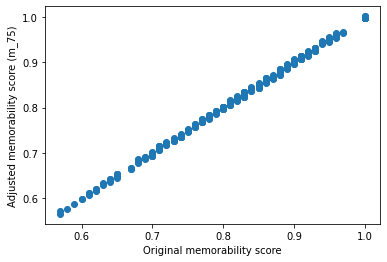

In [21]:
print("Average t:", np.mean(annotations["t"]))

# We use approximately the average_t to calculate T as the memorability in question
big_t = int(np.around(np.mean(annotations["t"])))
label = f"m_{big_t}"
print(f"Calculating adjusted value for {label}")
alpha, adjusted_score = calculate_alpha_and_memorability(annotations, T = big_t)
train_data[label] = adjusted_score
print(f"Alpha: {alpha}")
target_diff = train_data["part_1_scores"] - train_data[label]
print("Avg diff:", np.mean(target_diff))
print("Max diff:", np.max(target_diff))
print("Min diff:", np.min(target_diff))
plt.scatter(train_data["part_1_scores"], train_data[label])
plt.xlabel("Original memorability score")
plt.ylabel(f"Adjusted memorability score ({label})")
plt.show()

## Data Prep

Building datasets

potentially weighting samples based on annotations?



In [22]:
from train import split_training, build_matrixes

In [23]:
training_data, validation_data = split_training(train_data)
print("training:",len(training_data))
print("validation:", len(validation_data))

training: 472
validation: 118


#### Pick Features and Target

In [24]:
if FILTER_99:
    training_data = training_data[training_data[target] < .99]
    print(f"training after filtering for {target} < 0.99:", len(training_data))
    
if FILTER_99_VALID:
    validation_data = validation_data[validation_data[target] < 0.99]
    print(f"validation after filtering for {target} < 0.99:", len(validation_data))

In [25]:
features_train, targets_train, video_ids_train = build_matrixes(training_data, target_name = target, feature_name = feature)
features_valid, targets_valid, video_ids_valid = build_matrixes(validation_data, target_name = target, feature_name = feature)


print("num videos in training set:", len(training_data))
print("num videos in validation set:", len(validation_data))
print("features_train shape:", features_train.shape)
print("targets_train shape:", targets_train.shape)
print("features_valid shape:", features_valid.shape)
print("features_valid shape:", targets_valid.shape)
total_features = len(features_train) + len(features_valid)
unique, count = np.unique(np.concatenate([video_ids_valid, video_ids_train]), return_counts=True)
print("Total features:", total_features)
print("Total videos:", len(unique))
print("Avg features per video:", total_features / len(unique))
print("Min features per video:", min(count))
print("Max features per video:", max(count))

num videos in training set: 472
num videos in validation set: 118
features_train shape: (1757, 86, 300)
targets_train shape: (1757, 1)
features_valid shape: (434, 86, 300)
features_valid shape: (434, 1)
Total features: 2191
Total videos: 590
Avg features per video: 3.7135593220338983
Min features per video: 2
Max features per video: 5


## Model training

In [26]:
from train import train_two_layer_nn, train_svr, train_gru

def train_model(model_type, features_train, targets_train, features_valid, targets_valid):
    if "two_layer_nn" == model_type:
        model, train_losses, valid_losses = train_two_layer_nn(
            features_train, targets_train, features_valid, targets_valid,
            hidden_dim = 100,
            num_epochs=NUM_EPOCHS,
            cuda=CUDA,
            batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE
        )

        plt.plot(train_losses, label="Training Loss")
        plt.plot(valid_losses, label="Validation Loss")
        plt.legend()
        plt.show()

    elif "svr" == model_type:
        model = train_svr(features_train, targets_train)
        
    elif "gru" == model_type:
        model, train_losses, valid_losses = train_gru(
            features_train, targets_train, features_valid, targets_valid,
            hidden_dim = 64,
            num_epochs = 100,
            gru_units = 64,
            cuda = CUDA,
            batch_size = 128,
            learning_rate = LEARNING_RATE,
            verbose = True
        )
        plt.plot(train_losses, label="Training Loss")
        plt.plot(valid_losses, label="Validation Loss")
        plt.legend()
        plt.show()
    else:
        raise ValueError(f"'{model_type}' is not a valid model type")
    return model
        

input dimensions: (86, 300)
hidden dimension: 64
Train on 1757 samples, validate on 434 samples
Epoch 1/100
1728/1757 [============================>.] - ETA: 0s - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0887 - mean_absolute_percentage_error: 11.1748WARNING:tensorflow:From /home/tony/anaconda3/envs/video-mem/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


12-11-2020:13:31:57,736 WARNING  [deprecation.py:317] From /home/tony/anaconda3/envs/video-mem/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


1757/1757 [==============================] - 3s 1ms/sample - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0882 - mean_absolute_percentage_error: 11.1018 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1275 - val_mean_absolute_percentage_error: 14.7636
Epoch 2/100
1757/1757 [==============================] - 3s 1ms/sample - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0832 - mean_absolute_percentage_error: 10.4507 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1229 - val_mean_absolute_percentage_error: 14.2338
Epoch 3/100
1757/1757 [==============================] - 3s 1ms/sample - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0827 - mean_absolute_percentage_error: 10.3623 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1158 - val_mean_absolute_percentage_error: 13.4150
Epoch 4/100
1757/1757 [==============================] 

Epoch 27/100
1757/1757 [==============================] - 2s 1ms/sample - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0757 - mean_absolute_percentage_error: 9.4898 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0731 - val_mean_absolute_percentage_error: 9.2161
Epoch 28/100
1757/1757 [==============================] - 3s 1ms/sample - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0735 - mean_absolute_percentage_error: 9.2251 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0735 - val_mean_absolute_percentage_error: 9.3073
Epoch 29/100
1757/1757 [==============================] - 3s 1ms/sample - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0742 - mean_absolute_percentage_error: 9.3009 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0736 - val_mean_absolute_percentage_error: 9.3682
Epoch 30/100
1757/1757 [======================

Epoch 53/100
1757/1757 [==============================] - 2s 1ms/sample - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0720 - mean_absolute_percentage_error: 9.0312 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0741 - val_mean_absolute_percentage_error: 9.4812
Epoch 54/100
1757/1757 [==============================] - 3s 1ms/sample - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0709 - mean_absolute_percentage_error: 8.9014 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0740 - val_mean_absolute_percentage_error: 9.4478
Epoch 55/100
1757/1757 [==============================] - 2s 1ms/sample - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0706 - mean_absolute_percentage_error: 8.8596 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0743 - val_mean_absolute_percentage_error: 9.4716
Epoch 56/100
1757/1757 [======================

Epoch 79/100
1757/1757 [==============================] - 2s 1ms/sample - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0676 - mean_absolute_percentage_error: 8.4624 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0742 - val_mean_absolute_percentage_error: 9.4564
Epoch 80/100
1757/1757 [==============================] - 2s 1ms/sample - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0673 - mean_absolute_percentage_error: 8.4364 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0743 - val_mean_absolute_percentage_error: 9.4976
Epoch 81/100
1757/1757 [==============================] - 3s 1ms/sample - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0670 - mean_absolute_percentage_error: 8.4086 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0750 - val_mean_absolute_percentage_error: 9.6366
Epoch 82/100
1757/1757 [======================

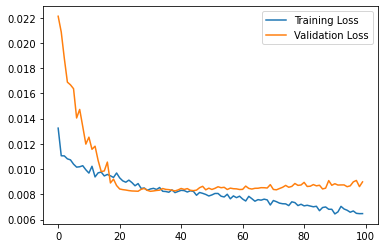

In [27]:
model = train_model(model_type, features_train, targets_train, features_valid, targets_valid)

## Test

Spearman's rank correlation, ROC curves, etc

In [39]:
from train import get_predictions

predictions, actuals, _ = get_predictions(
    model_type, model, features_valid, targets_valid, video_ids_valid, aggregate_with=np.median
)

SPEARMAN RANK: 0.26471136042422183


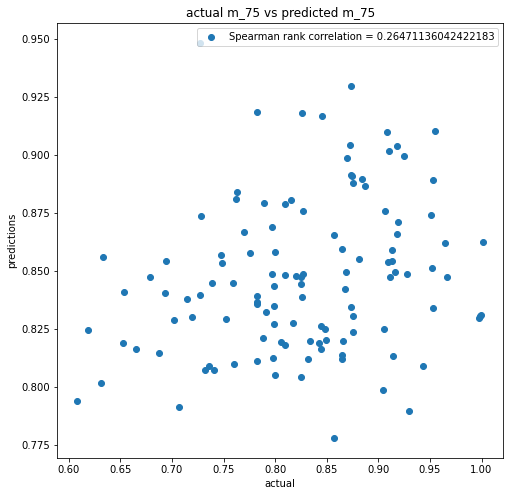

In [40]:
spearman_rank, _ = stats.spearmanr(actuals, predictions)
print("SPEARMAN RANK:",spearman_rank)

fig, ax = plt.subplots(1, figsize=(8,8))
min_mem = min(np.min(actuals), np.min(predictions))
max_mem = max(np.max(actuals), np.max(predictions))
plt.scatter(actuals, predictions, label = f"Spearman rank correlation = {spearman_rank}")
# plt.plot([min_mem, max_mem], [min_mem, max_mem], label="1 to 1")
plt.title(f"actual {target} vs predicted {target}")
plt.legend()
plt.ylabel("predictions")
plt.xlabel("actual")
plt.show()

# Saving Predictions


In [30]:
assert False, "stop auto run"

AssertionError: stop auto run

In [ ]:
pred_train, actual_train, vid_train = get_predictions(model_type, model, features_train, targets_train, video_ids_train)
pred_valid, actual_valid, vid_valid = get_predictions(model_type, model, features_valid, targets_valid, video_ids_valid)

In [ ]:
print("Validation spearman rank:", stats.spearmanr(actual_valid, pred_valid)[0])
print("Training spearman rank:", stats.spearmanr(actual_train, pred_train)[0])

In [ ]:
predictions = np.array(pred_train + pred_valid)
actuals = np.array(actual_train + actual_valid)
video_ids = np.array(vid_train + vid_valid)
in_training_set = np.array(np.concatenate([np.ones(len(pred_train)), np.zeros(len(pred_valid))]), dtype=bool)

In [ ]:
model_name = f"{feature}_{model_Type}"

In [ ]:
model_parameters = {
    "RANDOM_SEED": RANDOM_SEED
}

In [ ]:
def save_predictions(model_name, video_ids, actuals, predictions, in_training_set, model_parameters, predictions_dir = PREDICTIONS_DIR):

    if not os.path.exists(predictions_dir):
        os.mkdir(predictions_dir)
        
    model_data_dir = f"{predictions_dir}/model_data.csv"
    if not os.path.exists(model_data_dir):
        model_data = pd.DataFrame(columns=["name", "validation_spearman_rank", "parameters", "predictions", "notes", "is_short_term", "seed"])
    else:
        model_data = pd.read_csv(model_data_dir)
        
    model_dir = f"{predictions_dir}/{model_name}"
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
        
    pred_filename = f"{model_dir}/{len(os.listdir(model_dir))}.csv"
    
    valid_spearman_rank, _ = stats.spearmanr(actuals[in_training_set], predictions[in_training_set])
    
    pred_data = pd.DataFrame({
        "video_id": video_ids,
        "prediction": predictions,
        "actual": actuals,
        "in_training_set": in_training_set
    }).sort_values("video_id")
    
    pred_data.to_csv(pred_filename, index = False)
    
    model_info = {
        "name": model_name,
        "validation_spearman_rank": np.around(spearman_rank,4),
        "parameters": model_parameters,
        "predictions": pred_filename,
        "notes": "",
        "seed": RANDOM_SEED,
        "is_short_term": True
    }
    
    model_data.append(model_info, ignore_index = True).to_csv(model_data_dir, index = False)
    
    print("Saved model info and predictions: ", model_info)
    

In [ ]:
save_predictions(model_name, video_ids, actuals, predictions, in_training_set, model_parameters)